In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


In [6]:
def load_image_data(base_path, class_names, image_size=(64, 64)):
    X = []
    y = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_path, class_name)
        image_files = os.listdir(class_dir)
        for file_name in image_files:
            file_path = os.path.join(class_dir, file_name)
            try:
                img = Image.open(file_path).convert('L')  # Grayscale
                # Use LANCZOS resampling (equivalent to ANTIALIAS)
                img_resized = img.resize(image_size, resample=Image.LANCZOS)
                img_array = np.array(img_resized).flatten()
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y


In [7]:
# Define the base paths
train_base_path = '../Datasets/aqueduct, industrial_area, patio data sets/train/'
test_base_path = '../Datasets/aqueduct, industrial_area, patio data sets/test/'

# Class names corresponding to the folder names
class_names = ["aqueduct", "industrial_area", "patio"]

# Image size (adjust as needed)
image_size = (64, 64)

# Load training data
X_train, y_train = load_image_data(train_base_path, class_names, image_size=image_size)
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

# Load testing data
X_test, y_test = load_image_data(test_base_path, class_names, image_size=image_size)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (150, 4096)
Training labels shape: (150,)
Testing data shape: (150, 4096)
Testing labels shape: (150,)


In [8]:
# Normalize data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1  # Prevent division by zero
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std


In [9]:
def compute_pca(X, num_components):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    # Sort eigenvectors by eigenvalues in decreasing order
    sorted_indices = np.argsort(-eigvals)
    eigvecs = eigvecs[:, sorted_indices]
    # Select top components
    W_pca = eigvecs[:, :num_components]
    return W_pca

# Apply PCA
num_pca_components = 100  # Adjust as needed
W_pca = compute_pca(X_train_normalized, num_pca_components)
X_train_pca = np.dot(X_train_normalized, W_pca)
X_test_pca = np.dot(X_test_normalized, W_pca)

print("PCA reduced training data shape:", X_train_pca.shape)
print("PCA reduced testing data shape:", X_test_pca.shape)


PCA reduced training data shape: (150, 100)
PCA reduced testing data shape: (150, 100)


In [10]:
def compute_fda_multiclass(X_train, y_train, num_components=2):
    classes = np.unique(y_train)
    n_features = X_train.shape[1]
    overall_mean = np.mean(X_train, axis=0)
    S_B = np.zeros((n_features, n_features))
    S_W = np.zeros((n_features, n_features))
    for cls in classes:
        X_cls = X_train[y_train == cls]
        n_cls = X_cls.shape[0]
        mean_cls = np.mean(X_cls, axis=0)
        mean_diff = (mean_cls - overall_mean).reshape(-1,1)
        S_B += n_cls * np.dot(mean_diff, mean_diff.T)
        X_cls_centered = X_cls - mean_cls
        S_W += np.dot(X_cls_centered.T, X_cls_centered)
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
    sorted_indices = np.argsort(-eigvals.real)
    W_fda = eigvecs[:, sorted_indices[:num_components]].real
    return W_fda

# Compute FDA projection matrix
W_fda = compute_fda_multiclass(X_train_pca, y_train, num_components=2)

# Project data onto FDA components
X_train_fda = np.dot(X_train_pca, W_fda)
X_test_fda = np.dot(X_test_pca, W_fda)

print("FDA projected training data shape:", X_train_fda.shape)
print("FDA projected testing data shape:", X_test_fda.shape)


FDA projected training data shape: (150, 2)
FDA projected testing data shape: (150, 2)


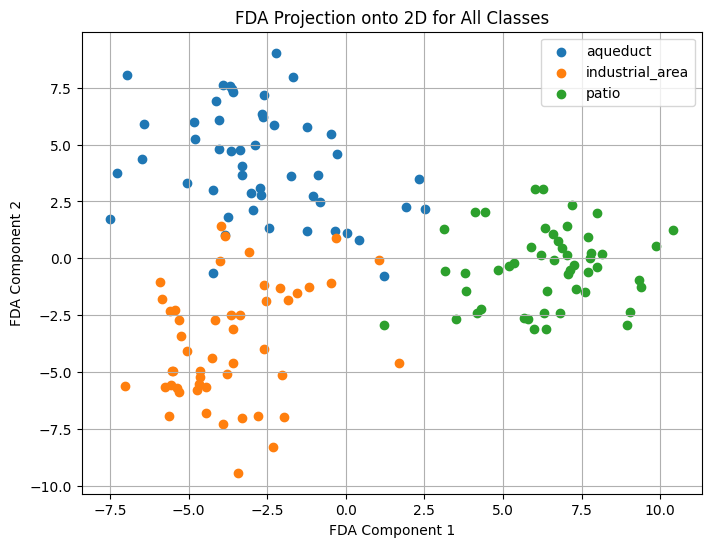

In [11]:
# Plot the 2D projected data for all classes
plt.figure(figsize=(8, 6))
for cls in np.unique(y_train):
    X_cls = X_train_fda[y_train == cls]
    plt.scatter(X_cls[:, 0], X_cls[:, 1], label=f'{class_names[cls]}')
plt.title('FDA Projection onto 2D for All Classes')
plt.xlabel('FDA Component 1')
plt.ylabel('FDA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Estimate mean and covariance for each class in the projected space
class_params = {}
for cls in np.unique(y_train):
    X_cls = X_train_fda[y_train == cls]
    mean = np.mean(X_cls, axis=0)
    cov = np.cov(X_cls, rowvar=False)
    class_params[cls] = (mean, cov)

# Compute class priors
class_priors = {}
total_samples = len(y_train)
for cls in np.unique(y_train):
    n_cls = np.sum(y_train == cls)
    class_priors[cls] = n_cls / total_samples


In [13]:
def multivariate_gaussian_pdf(x, mean, cov):
    size = mean.shape[0]
    det = np.linalg.det(cov)
    if det == 0:
        det += 1e-6  # Avoid division by zero
    norm_const = 1.0 / (np.power((2*np.pi), float(size)/2) * np.sqrt(det))
    x_mu = x - mean
    inv = np.linalg.pinv(cov)
    result = np.einsum('...k,kl,...l->...', x_mu, inv, x_mu)
    return norm_const * np.exp(-0.5 * result)


In [14]:
# Classify test samples
y_pred = []
for x in X_test_fda:
    posteriors = []
    for cls in np.unique(y_train):
        mean, cov = class_params[cls]
        prior = class_priors[cls]
        likelihood = multivariate_gaussian_pdf(x, mean, cov)
        posterior = likelihood * prior
        posteriors.append(posterior)
    predicted_class = np.argmax(posteriors)
    y_pred.append(predicted_class)
y_pred = np.array(y_pred)


In [15]:
def compute_confusion_matrix(y_true, y_pred, classes):
    conf_mat = np.zeros((len(classes), len(classes)), dtype=int)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}
    for true_label, pred_label in zip(y_true, y_pred):
        i = class_to_index[true_label]
        j = class_to_index[pred_label]
        conf_mat[i, j] += 1
    return conf_mat

def compute_classification_metrics(conf_mat):
    num_classes = conf_mat.shape[0]
    precision = []
    recall = []
    f1_score = []
    for cls in range(num_classes):
        tp = conf_mat[cls, cls]
        fp = np.sum(conf_mat[:, cls]) - tp
        fn = np.sum(conf_mat[cls, :]) - tp
        tn = np.sum(conf_mat) - (tp + fp + fn)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1_score = np.mean(f1_score)
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    return precision, mean_precision, recall, mean_recall, f1_score, mean_f1_score, accuracy


In [16]:
# Compute confusion matrix
classes = np.unique(y_train)
conf_mat = compute_confusion_matrix(y_test, y_pred, classes)

# Compute metrics
precision, mean_precision, recall, mean_recall, f1_score, mean_f1_score, accuracy = compute_classification_metrics(conf_mat)

# Print results
print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy:.4f}")
for idx, cls in enumerate(classes):
    print(f"Class {class_names[cls]}: Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}, F1-Score={f1_score[idx]:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1_score:.4f}")


Confusion Matrix:
[[22 11 17]
 [11 35  4]
 [13  6 31]]
Accuracy: 0.5867
Class aqueduct: Precision=0.4783, Recall=0.4400, F1-Score=0.4583
Class industrial_area: Precision=0.6731, Recall=0.7000, F1-Score=0.6863
Class patio: Precision=0.5962, Recall=0.6200, F1-Score=0.6078
Mean Precision: 0.5825
Mean Recall: 0.5867
Mean F1-Score: 0.5842


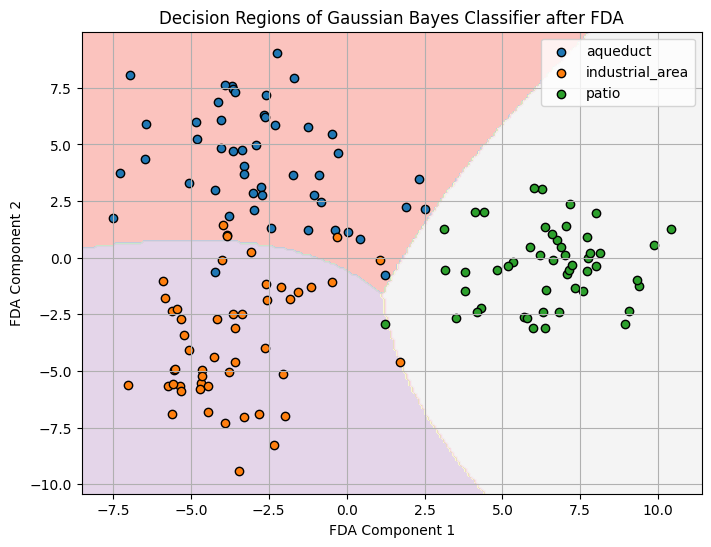

In [17]:
# Plot decision regions in the FDA projected space
h = 0.1  # Step size in the mesh
x_min, x_max = X_train_fda[:, 0].min() - 1, X_train_fda[:, 0].max() + 1
y_min, y_max = X_train_fda[:, 1].min() - 1, X_train_fda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Classify grid points
posteriors = np.zeros((len(classes), len(grid_points)))
for idx, cls in enumerate(classes):
    mean, cov = class_params[cls]
    prior = class_priors[cls]
    likelihood = multivariate_gaussian_pdf(grid_points, mean, cov)
    posteriors[idx, :] = likelihood * prior

predicted_classes = classes[np.argmax(posteriors, axis=0)]
grid_preds = predicted_classes.reshape(xx.shape)

# Plot the decision boundary and training data
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.Pastel1, alpha=0.8)
for cls in classes:
    idxs = y_train == cls
    plt.scatter(X_train_fda[idxs, 0], X_train_fda[idxs, 1], label=f'{class_names[cls]}', edgecolor='k')
plt.title('Decision Regions of Gaussian Bayes Classifier after FDA')
plt.xlabel('FDA Component 1')
plt.ylabel('FDA Component 2')
plt.legend()
plt.grid(True)
plt.show()


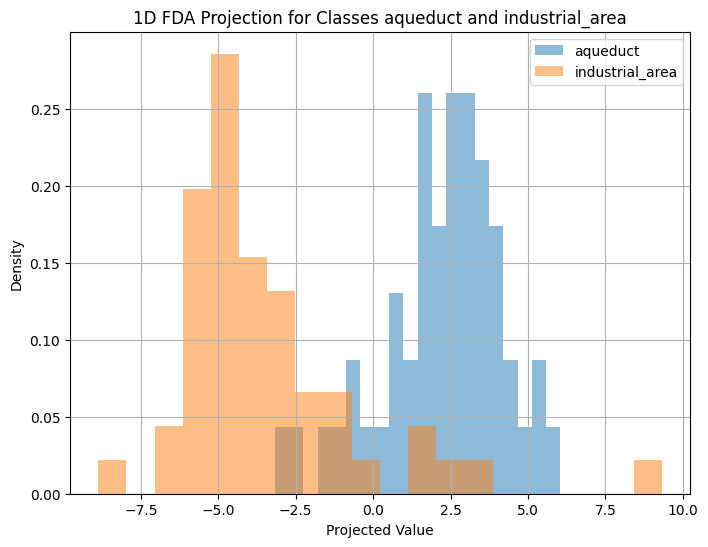

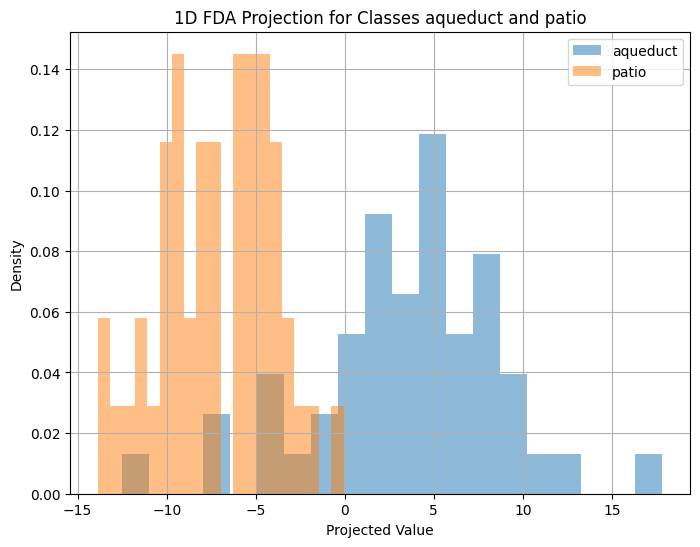

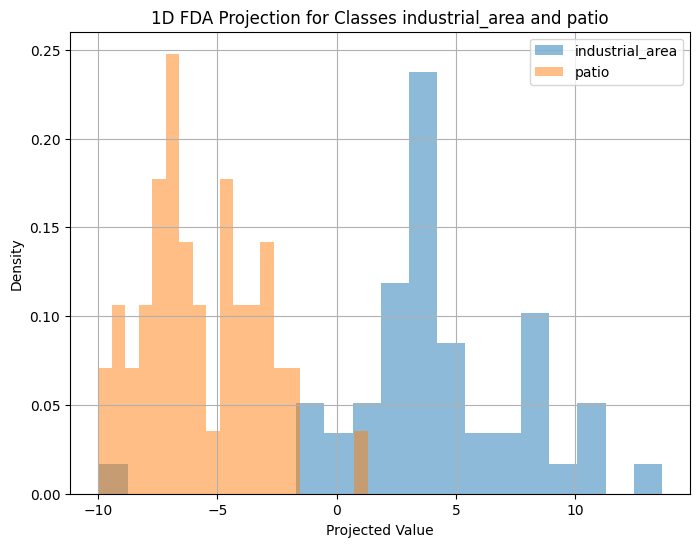

In [18]:
# Assuming all previous code has been executed, and we have:
# X_train_normalized, y_train, class_names

# Define pairs of classes
pairs = [(0, 1), (0, 2), (1, 2)]

def compute_fda_two_classes(X1, X2):
    # Compute class means
    mean1 = np.mean(X1, axis=0)
    mean2 = np.mean(X2, axis=0)
    # Compute within-class scatter matrices
    S_W = np.cov(X1, rowvar=False) * (X1.shape[0] - 1) + np.cov(X2, rowvar=False) * (X2.shape[0] - 1)
    # Compute FDA projection vector
    S_W_inv = np.linalg.pinv(S_W)
    w = np.dot(S_W_inv, (mean1 - mean2))
    # Normalize w
    w = w / np.linalg.norm(w)
    return w

for (class1, class2) in pairs:
    # Extract data for the two classes
    idx1 = y_train == class1
    idx2 = y_train == class2
    X1 = X_train_normalized[idx1]
    X2 = X_train_normalized[idx2]
    y1 = y_train[idx1]
    y2 = y_train[idx2]
    
    # Apply PCA to reduce dimensionality (if needed)
    # Combine data
    X_pair = np.vstack((X1, X2))
    y_pair = np.hstack((y1, y2))
    # Compute PCA on the pair data
    num_pca_components_pair = min(100, X_pair.shape[1])  # Ensure we don't have more components than features
    W_pca_pair = compute_pca(X_pair, num_pca_components_pair)
    X_pair_pca = np.dot(X_pair, W_pca_pair)
    
    # Re-separate the data after PCA
    X1_pca = X_pair_pca[:len(X1)]
    X2_pca = X_pair_pca[len(X1):]
    
    # Compute FDA projection vector for the pair
    w = compute_fda_two_classes(X1_pca, X2_pca)
    
    # Project data onto FDA vector
    X1_proj = np.dot(X1_pca, w)
    X2_proj = np.dot(X2_pca, w)
    
    # Plot histograms of projected data
    plt.figure(figsize=(8, 6))
    plt.hist(X1_proj, bins=20, alpha=0.5, label=f'{class_names[class1]}', density=True)
    plt.hist(X2_proj, bins=20, alpha=0.5, label=f'{class_names[class2]}', density=True)
    plt.title(f'1D FDA Projection for Classes {class_names[class1]} and {class_names[class2]}')
    plt.xlabel('Projected Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [20]:
# Fit a GMM to the projected training data of each class
n_components = 2  # Number of Gaussian components in the mixture for each class; adjust as needed

gmm_models = {}
for cls in np.unique(y_train):
    X_cls = X_train_fda[y_train == cls]
    # Initialize and fit the GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_cls)
    gmm_models[cls] = gmm


In [21]:
# Classify test samples
y_pred = []
for x in X_test_fda:
    posteriors = []
    for cls in np.unique(y_train):
        gmm = gmm_models[cls]
        prior = class_priors[cls]
        # Compute the likelihood of x under the GMM of the class
        likelihood = np.exp(gmm.score_samples([x]))[0]  # gmm.score_samples returns log likelihood
        posterior = likelihood * prior
        posteriors.append(posterior)
    predicted_class = np.argmax(posteriors)
    y_pred.append(predicted_class)
y_pred = np.array(y_pred)


In [22]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
mean_precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average=None)
mean_recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average=None)
mean_f1 = f1_score(y_test, y_pred, average='macro')

# Print results
print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy:.4f}")
for idx, cls in enumerate(classes):
    print(f"Class {class_names[cls]}: Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}, F1-Score={f1[idx]:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


Confusion Matrix:
[[24 12 14]
 [ 9 37  4]
 [15  7 28]]
Accuracy: 0.5933
Class aqueduct: Precision=0.5000, Recall=0.4800, F1-Score=0.4898
Class industrial_area: Precision=0.6607, Recall=0.7400, F1-Score=0.6981
Class patio: Precision=0.6087, Recall=0.5600, F1-Score=0.5833
Mean Precision: 0.5898
Mean Recall: 0.5933
Mean F1-Score: 0.5904


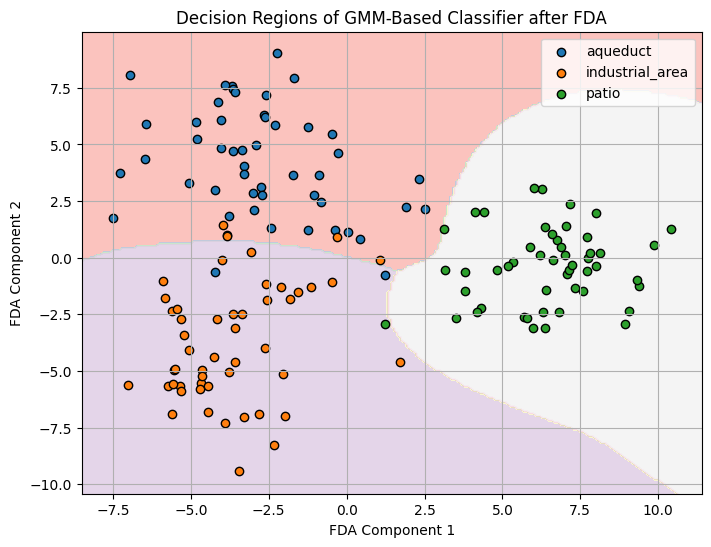

In [23]:
# Plot decision regions in the FDA projected space
h = 0.1  # Step size in the mesh
x_min, x_max = X_train_fda[:, 0].min() - 1, X_train_fda[:, 0].max() + 1
y_min, y_max = X_train_fda[:, 1].min() - 1, X_train_fda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Classify grid points
posteriors = np.zeros((len(classes), len(grid_points)))
for idx, cls in enumerate(classes):
    gmm = gmm_models[cls]
    prior = class_priors[cls]
    # Compute the likelihoods for all grid points
    log_likelihood = gmm.score_samples(grid_points)  # Returns log likelihood
    likelihood = np.exp(log_likelihood)
    posteriors[idx, :] = likelihood * prior

predicted_classes = classes[np.argmax(posteriors, axis=0)]
grid_preds = predicted_classes.reshape(xx.shape)

# Plot the decision boundary and training data
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.Pastel1, alpha=0.8)
for cls in classes:
    idxs = y_train == cls
    plt.scatter(X_train_fda[idxs, 0], X_train_fda[idxs, 1], label=f'{class_names[cls]}', edgecolor='k')
plt.title('Decision Regions of GMM-Based Classifier after FDA')
plt.xlabel('FDA Component 1')
plt.ylabel('FDA Component 2')
plt.legend()
plt.grid(True)
plt.show()



--- GMM with 2 mixture components per class ---
Confusion Matrix:
[[24 12 14]
 [ 9 37  4]
 [15  7 28]]
Accuracy: 0.5933
Class aqueduct: Precision=0.5000, Recall=0.4800, F1-Score=0.4898
Class industrial_area: Precision=0.6607, Recall=0.7400, F1-Score=0.6981
Class patio: Precision=0.6087, Recall=0.5600, F1-Score=0.5833
Mean Precision: 0.5898
Mean Recall: 0.5933
Mean F1-Score: 0.5904


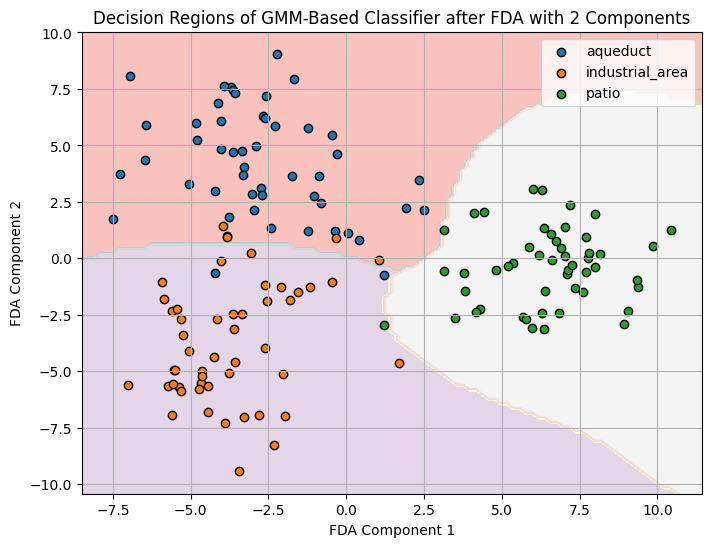


--- GMM with 4 mixture components per class ---
Confusion Matrix:
[[25 13 12]
 [ 8 38  4]
 [17  9 24]]
Accuracy: 0.5800
Class aqueduct: Precision=0.5000, Recall=0.5000, F1-Score=0.5000
Class industrial_area: Precision=0.6333, Recall=0.7600, F1-Score=0.6909
Class patio: Precision=0.6000, Recall=0.4800, F1-Score=0.5333
Mean Precision: 0.5778
Mean Recall: 0.5800
Mean F1-Score: 0.5747


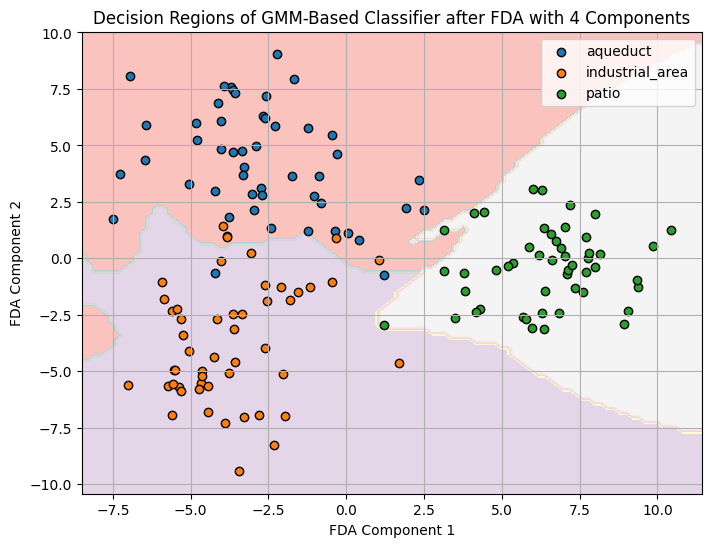


--- GMM with 8 mixture components per class ---
Confusion Matrix:
[[27  7 16]
 [16 25  9]
 [18  5 27]]
Accuracy: 0.5267
Class aqueduct: Precision=0.4426, Recall=0.5400, F1-Score=0.4865
Class industrial_area: Precision=0.6757, Recall=0.5000, F1-Score=0.5747
Class patio: Precision=0.5192, Recall=0.5400, F1-Score=0.5294
Mean Precision: 0.5458
Mean Recall: 0.5267
Mean F1-Score: 0.5302


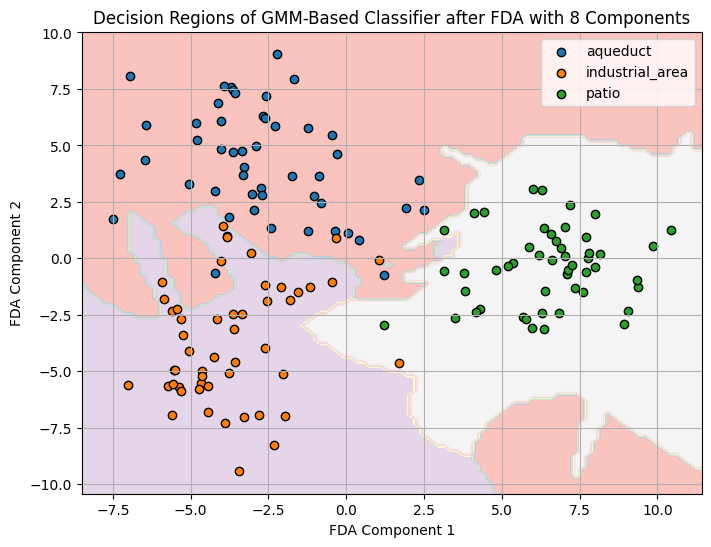

In [24]:
# List of mixture components to try
n_components_list = [2, 4, 8]

# For storing results
results = []

for n_components in n_components_list:
    print(f"\n--- GMM with {n_components} mixture components per class ---")

    # 7. Fit GMMs to Each Class
    gmm_models = {}
    for cls in np.unique(y_train):
        X_cls = X_train_fda[y_train == cls]
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(X_cls)
        gmm_models[cls] = gmm

    # 8. Classify Test Samples Using GMMs
    y_pred = []
    for x in X_test_fda:
        posteriors = []
        x_reshaped = x.reshape(1, -1)  # Ensure x is a 2D array
        for cls in np.unique(y_train):
            gmm = gmm_models[cls]
            prior = class_priors[cls]
            log_likelihood = gmm.score_samples(x_reshaped)
            likelihood = np.exp(log_likelihood)[0]
            posterior = likelihood * prior
            posteriors.append(posterior)
        predicted_class = np.argmax(posteriors)
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)

    # 9. Evaluate the Classifier
    conf_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    mean_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    mean_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_score_vals = f1_score(y_test, y_pred, average=None, zero_division=0)
    mean_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Store results
    results.append({
        'n_components': n_components,
        'conf_mat': conf_mat,
        'accuracy': accuracy,
        'precision': precision,
        'mean_precision': mean_precision,
        'recall': recall,
        'mean_recall': mean_recall,
        'f1_score_vals': f1_score_vals,
        'mean_f1': mean_f1
    })

    # Print results
    print("Confusion Matrix:")
    print(conf_mat)
    classes = np.unique(y_train)
    print(f"Accuracy: {accuracy:.4f}")
    for idx, cls in enumerate(classes):
        print(f"Class {class_names[cls]}: Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}, F1-Score={f1_score_vals[idx]:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

        # 10. Plot Class Likelihoods and Projected Data
    x_min_plot = X_train_fda[:, 0].min() - 1
    x_max_plot = X_train_fda[:, 0].max() + 1
    y_min_plot = X_train_fda[:, 1].min() - 1
    y_max_plot = X_train_fda[:, 1].max() + 1
    xx_plot, yy_plot = np.meshgrid(np.linspace(x_min_plot, x_max_plot, 100),
                                   np.linspace(y_min_plot, y_max_plot, 100))
    grid_points = np.c_[xx_plot.ravel(), yy_plot.ravel()]

    # Classify grid points
    posteriors = np.zeros((len(classes), len(grid_points)))
    for idx, cls in enumerate(classes):
        gmm = gmm_models[cls]
        prior = class_priors[cls]
        log_likelihood = gmm.score_samples(grid_points)
        likelihood = np.exp(log_likelihood)
        posteriors[idx, :] = likelihood * prior

    predicted_classes = classes[np.argmax(posteriors, axis=0)]
    grid_preds = predicted_classes.reshape(xx_plot.shape)

    # Plot the decision boundary and training data
    plt.figure(figsize=(8, 6))
    plt.contourf(xx_plot, yy_plot, grid_preds, cmap=plt.cm.Pastel1, alpha=0.8)
    for cls in classes:
        idxs = y_train == cls
        plt.scatter(X_train_fda[idxs, 0], X_train_fda[idxs, 1], label=f'{class_names[cls]}', edgecolor='k')
    plt.title(f'Decision Regions of GMM-Based Classifier after FDA with {n_components} Components')
    plt.xlabel('FDA Component 1')
    plt.ylabel('FDA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()
